<a href="https://colab.research.google.com/github/rawar/tensorflow-notebooks/blob/master/lstm_sentiment_detection_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple LSTM to learn sentiment detection from Yelp data 

### Install Tensorflow 2.0 alpha witj GPU support (only for Notebooks with GPU support)

In [1]:
#!pip install tensorflow-gpu==2.0.0-alpha0
#!pip install tensorflow==2.0.0-alpha0
!pip install tensorflow-gpu

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf


### get the Yelp sentiment data from GitHub Gist 

In [0]:
url = 'https://gist.githubusercontent.com/rawar/3d5343ce39dd16bc457ef4ae56c87f4a/raw/6e6c150745de44e002f0b7fb435d0ccd1e10faa7/yelp-sentiment-data.csv'
sentiment_data = pd.read_csv(url)

### take a look to the data

In [4]:
sentiment_data.head(5)

,Unnamed: 0,stars,text,sentiment
0,0,5.0,hands down best bloody mary ever so many thing...,pos
1,1,5.0,its true this hotel carries you while in vegas...,pos
2,2,4.0,first time lemme not exaggerate but yo nothin...,pos
3,3,4.0,sushisamba had very tasty sushis my table and ...,pos
4,4,5.0,good food nice setting jazz ambience\n\nmade f...,pos


### remove some empty values

In [0]:
sentiment_data = sentiment_data.dropna()

In [0]:
sentiment_data = sentiment_data.applymap(lambda x: x.strip() if type(x)==str else x)

In [7]:
print(sentiment_data['text'].values)

['hands down best bloody mary ever so many things in my bm veggies  mmm bacon  nailed it its an appetizer i also had the burger with fries who knew fries could be so good the presentation doesnt disappoint ether very nice great seating outside although we sat inside would love to see this restaurant near my hometown seriously get the bm you rock guy'
 'its true this hotel carries you while in vegas we visited the venetian to experience the awesome interior and romantic evening events the entire hotel sparkled its huge too  weekendinvegas'
 'first time  lemme not exaggerate but yo nothing but love and fun cups full and aint nothing but love nothing but good vibes tonight some people dapper some people coolin all age groups people eating'
 ...
 'if i could give this place  stars i would handsdown the best service ive received at a shisha spot worldwide \n\ni was taken care of from the moment i walked in to when i walked out the staff were so attentive and checked on me nonstop they def k

### tokenize text reviews

In [0]:
vocab_size = 4700

In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, lower=False, split=" ")

In [0]:
tokenizer.fit_on_texts(sentiment_data['text'].values)

In [11]:
print('Number of words: %d' % len(tokenizer.word_index))

Number of words: 25474


In [0]:
X = tokenizer.texts_to_sequences(sentiment_data['text'].values)

### fill empty words with none to bring every review to the same world length

In [0]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=vocab_size)

In [14]:
print(X.shape[1])

4700


In [0]:
embed_dim = 32
e_init = tf.keras.initializers.RandomUniform(-0.01, 0.01, seed=1)
init = tf.keras.initializers.glorot_uniform(seed=1)

In [18]:


#tf.keras.layers.CuDNNLSTM
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,embeddings_initializer=e_init, input_length=X.shape[1]),
    #tf.keras.layers.LSTM(60, return_sequences=True, recurrent_dropout=0.5),
    #tf.keras.layers.LSTM(60, return_sequences=True, dropout=0.5),
    #tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.CuDNNLSTM(units=100, kernel_initializer=init),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.LSTM(60, recurrent_dropout=0.5),
    #tf.keras.layers.LSTM(60, dropout=0.5),
    #tf.keras.layers.LSTM(60, return_sequences=True),
    #tf.keras.layers.LSTM(60),
    #tf.keras.layers.Dropout(0.2),    
    #tf.keras.layers.Dense(60, activation='relu'),
    #tf.keras.layers.Dense(2,activation='softmax') # classification layer with two classes (neg, pos)
    tf.keras.layers.Dense(units=2, kernel_initializer=init, activation='sigmoid')
])

#model = tf.keras.models.Sequential([
#    tf.keras.layers.Embedding(vocab_size, embed_dim, input_length=X.shape[1]),
#    tf.keras.layers.LSTM(60, recurrent_dropout=0.5),
#    tf.keras.layers.Dense(2,activation='softmax') # classification layer with two classes (neg, pos)
#])

adam_optimizer = tf.keras.optimizers.Adam(lr=0.01, decay=0.001)
model.compile(loss = 'binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
print(model.summary())  

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 4700, 32)          150400    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               53600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 204,202
Trainable params: 204,202
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
print(sentiment_data['sentiment'].head(5))

0    pos
1    pos
2    pos
3    pos
4    pos
Name: sentiment, dtype: object


### 1 = postive, 0 = negativ

In [20]:
Y = pd.get_dummies(sentiment_data['sentiment']).values
print(Y)

[[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.2, random_state = 42)

In [22]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,4690,4691,4692,4693,4694,4695,4696,4697,4698,4699
0,0,0,0,0,0,0,0,0,0,0,...,23,4,130,115,27,1,1282,228,435,19
1,0,0,0,0,0,0,0,0,0,0,...,150,11,6,133,4391,2,144,858,26,208
2,0,0,0,0,0,0,0,0,0,0,...,16,9,41,375,210,2,252,344,183,173
3,0,0,0,0,0,0,0,0,0,0,...,309,2,120,34,1706,16,29,9,4,387
4,0,0,0,0,0,0,0,0,0,0,...,579,6,219,18,2048,70,618,97,80,283


In [23]:
pd.DataFrame(Y_train).head()

,0,1
0,0,1
1,0,1
2,1,0
3,0,1
4,1,0


In [0]:
num_epochs = 3
batch_size = 32

In [25]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size = batch_size, epochs = num_epochs, verbose = 1)

Train on 5251 samples, validate on 1313 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
5251/5251 [==============================] - 90s 17ms/sample - loss: 0.5350 - acc: 0.7342 - val_loss: 0.6003 - val_acc: 0.7011
Epoch 2/3
5251/5251 [==============================] - 88s 17ms/sample - loss: 0.3126 - acc: 0.8707 - val_loss: 0.4244 - val_acc: 0.8130
Epoch 3/3
5251/5251 [==============================] - 88s 17ms/sample - loss: 0.1796 - acc: 0.9301 - val_loss: 0.4942 - val_acc: 0.8252


In [26]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


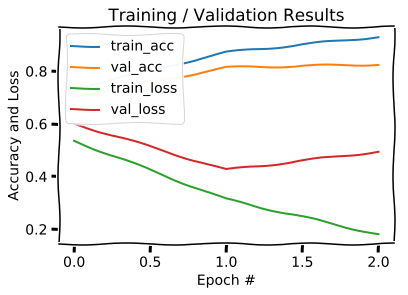

In [28]:
from matplotlib import pyplot

pyplot.xkcd()
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Training / Validation Results')
pyplot.ylabel('Accuracy and Loss')
pyplot.xlabel('Epoch #')
pyplot.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc='upper left')
pyplot.show()



In [0]:
score,acc = model.evaluate(X_val, Y_val, verbose = 2, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

In [0]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_val)):
    
    result = model.predict(X_val[x].reshape(1,X_val.shape[1]), batch_size=1, verbose = 0)[0]
    
    if np.argmax(result) == np.argmax(Y_val[x]):
        if np.argmax(Y_val[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
            
    if np.argmax(Y_val[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

In [0]:
print("positive accuracy: %.2f" % (pos_correct/pos_cnt*100))
print("negative accuracy: %.2f" % (neg_correct/neg_cnt*100))

### Serialize the Keras model to JSON and save the model weight

In [0]:
from google.colab import files

In [0]:
model_json = model.to_json()
with open("yelp-sentiment-model.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
files.download("yelp-sentiment-model.json")

In [0]:
model.save_weights("yelp-sentiment-model.h5")
print("Saved model to disk")

In [0]:
files.download('yelp-sentiment-model-model.h5')

### Load model and use it to predict new reviews

In [0]:
!ls -l

In [0]:
!pip install h5py

In [0]:
json_file = open('yelp-sentiment-model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights("yelp-sentiment-model.h5")
 
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_val, Y_val, verbose=0)

In [0]:
xval = X_val[1].reshape(1,X_val.shape[1])
print(xval)

In [0]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

def sequence_to_text(list_of_indices):
    words = []
    for letter in list_of_indices:
        w = reverse_word_map.get(letter)
        if(w != None):
            words.append(w)
    return(words)

In [0]:
xval_str = list(map(sequence_to_text, xval))

In [0]:
print(xval.shape)

In [0]:
yresult = loaded_model.predict(xval)
print("words=%s, predicted sentiment=%s" % (xval_str, yresult))

In [0]:
# 1 = positiv, 0 = negativ
result = loaded_model.predict_classes(xval)
print(result)

In [0]:
yhat = loaded_model.predict_proba(xval) 
print(yhat)